# Clusterisation pour savoir quand la météo est mauvaise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../Datas/data.csv")

In [3]:
df.head(1)

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count,day,month,day_number,year,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0,16,Saturday,1,1,2011,0


## Choix des colonnes en rapport avec la météo

In [4]:
df.drop(["datetime", "season", "holiday", "workingday", "count", "day", "hour", "month", "year", "day_number", "weather"], axis=1,inplace=True)

## Clusterisation avec KMeans

In [5]:
from sklearn.cluster import KMeans

### Techniques des coudes

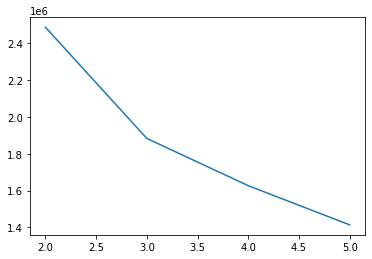

In [6]:
y = []
x = []
for i in range (2,6):
    x.append(i)
    k_means = KMeans(n_clusters=i).fit(df)
    y.append(k_means.inertia_)

plt.plot(x, y)

Présence d'un coude très visible à 3 clusters

### Silhouette score

In [7]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For n_clusters = 2 The average silhouette_score is : 0.43606493051300654
For n_clusters = 3 The average silhouette_score is : 0.32203324137299466
For n_clusters = 4 The average silhouette_score is : 0.29146024028688644
For n_clusters = 5 The average silhouette_score is : 0.27733439352666284
For n_clusters = 6 The average silhouette_score is : 0.2686226734559664


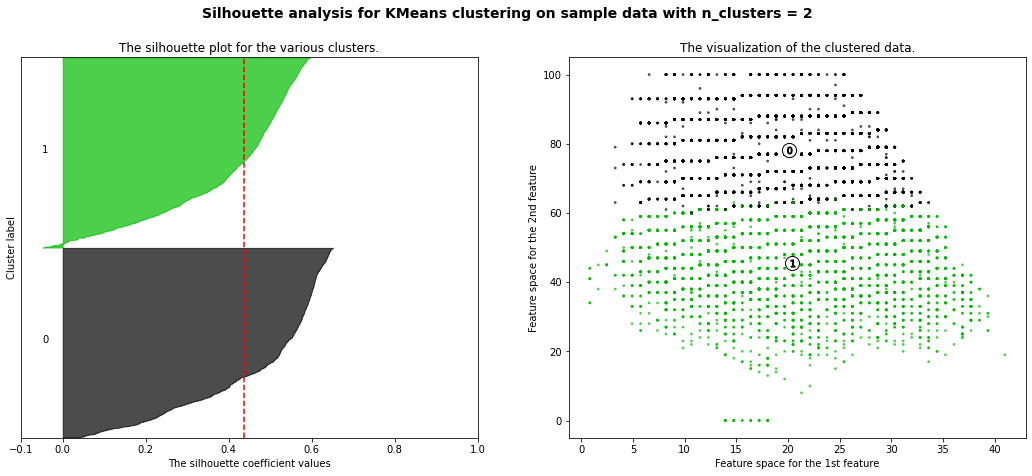

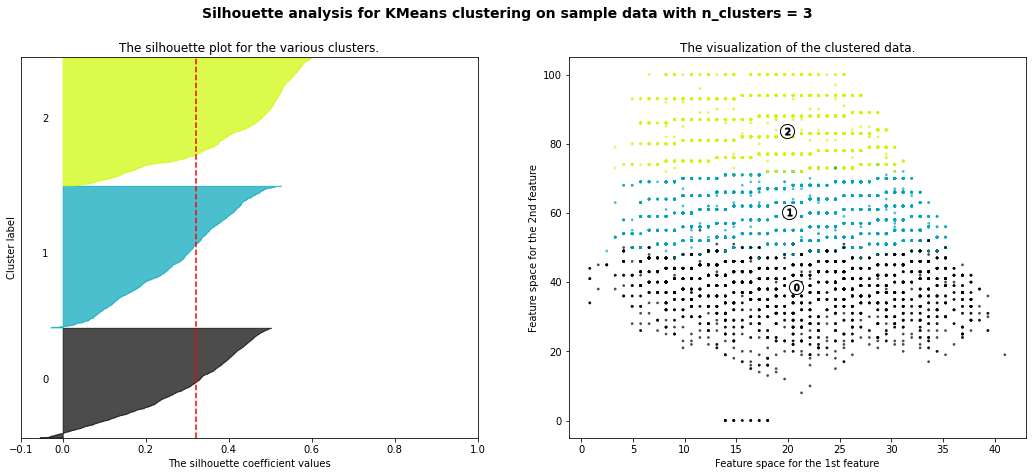

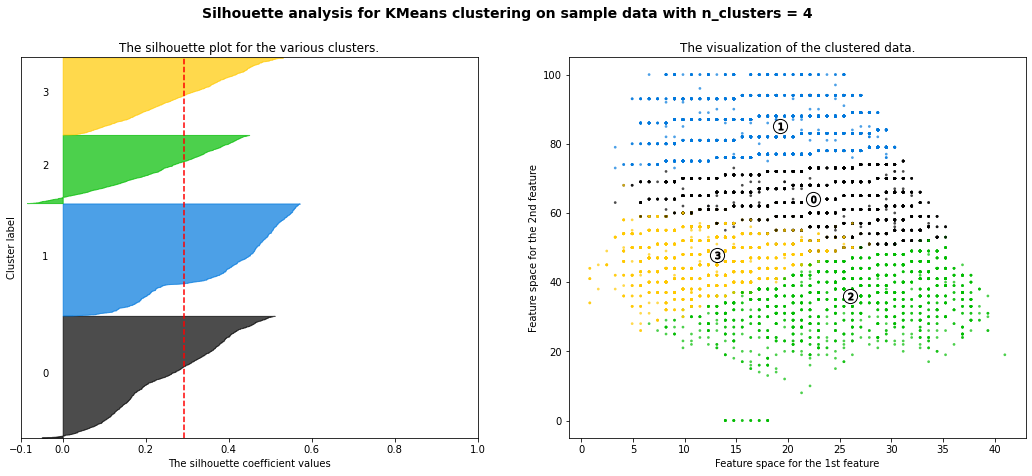

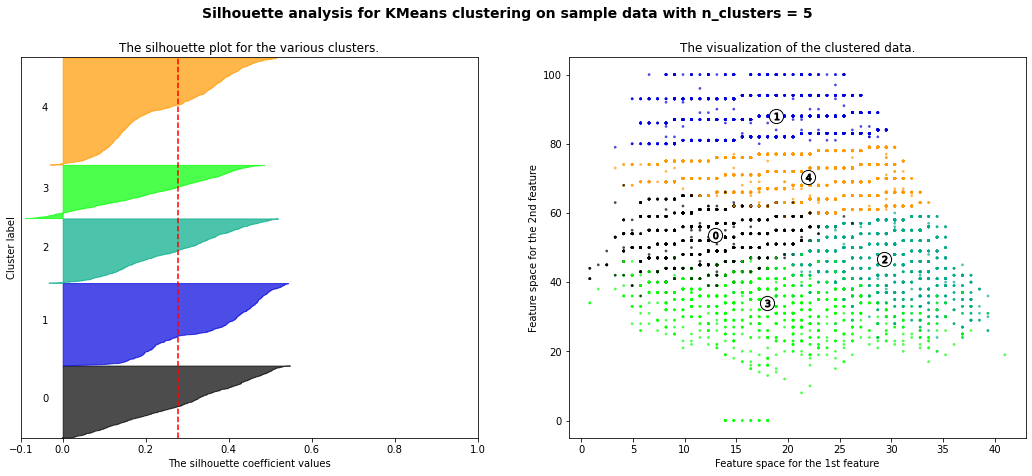

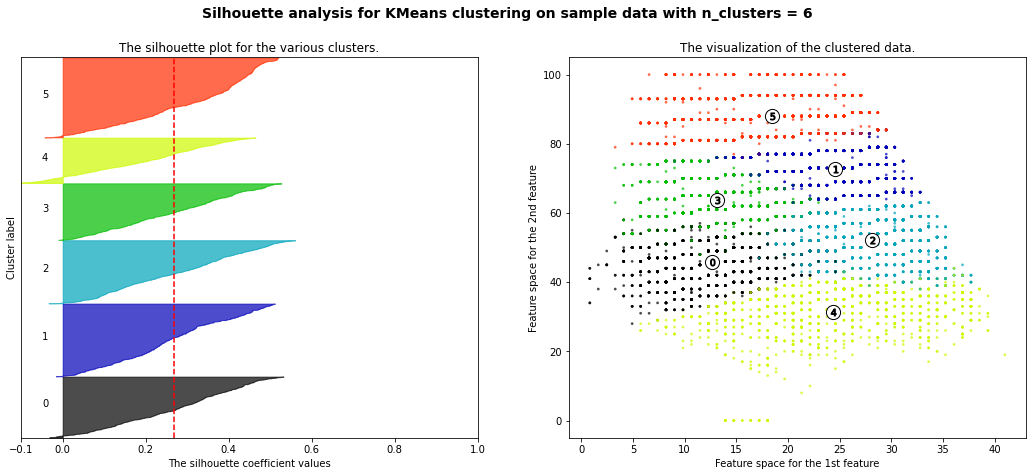

In [8]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        df.iloc[:, 0], df.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

2 ou 3 clusters ici avec cette méthode serait idéal.  

On choisira donc d'utiliser **3 clusters**

## Visualisation des clusters avec une PCA

### PCA

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=0.9999)
components = pca.fit_transform(df)
pca.explained_variance_ratio_

array([0.76081984, 0.12524259, 0.11393757])

In [11]:
df_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(components)], axis=1)
df_pca.columns.values[-3:] = ["F" + str(i) for i in range(1,4)]
df_pca.head()

,temp,humidity,windspeed,F1,F2,F3
0,9.84,81,0.0,-21.197781,2.338983,-13.502042
1,9.02,80,0.0,-20.235149,2.936788,-14.125234
2,9.02,80,0.0,-20.235149,2.936788,-14.125234
3,9.84,75,0.0,-15.276049,1.928519,-14.376459
4,9.84,75,0.0,-15.276049,1.928519,-14.376459


### Clustering

In [12]:
clusters = 3
k_means = KMeans(random_state=1, n_clusters=clusters)
y_pred = k_means.fit_predict(df)

df_pca["cluster"] = y_pred
df_pca.head()

,temp,humidity,windspeed,F1,F2,F3,cluster
0,9.84,81,0.0,-21.197781,2.338983,-13.502042,2
1,9.02,80,0.0,-20.235149,2.936788,-14.125234,2
2,9.02,80,0.0,-20.235149,2.936788,-14.125234,2
3,9.84,75,0.0,-15.276049,1.928519,-14.376459,2
4,9.84,75,0.0,-15.276049,1.928519,-14.376459,2


### Visualisation

In [13]:
import seaborn as sns

/tmp/ipykernel_16391/3376386721.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


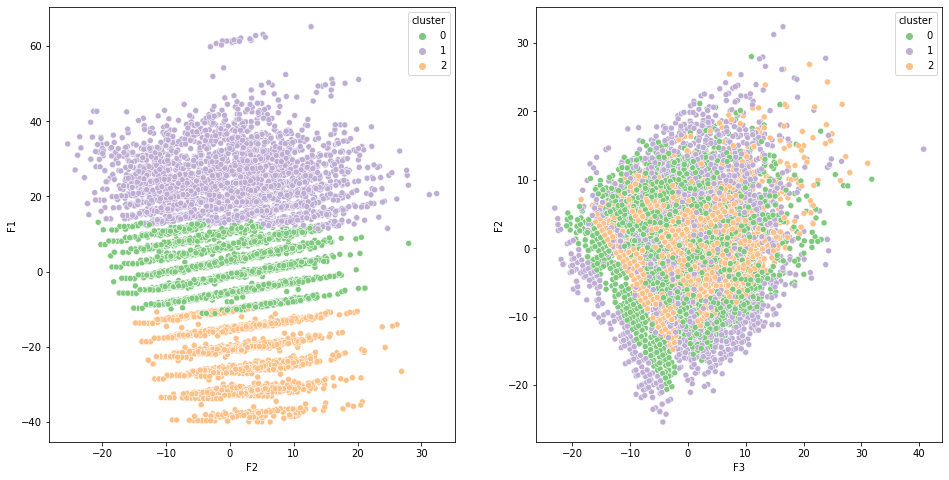

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
sns.scatterplot(ax=ax1, x=df_pca[f"F{2}"], y=df_pca[f"F{1}"], hue=df_pca.cluster, palette="Accent")
sns.scatterplot(ax=ax2, x=df_pca[f"F{3}"], y=df_pca[f"F{2}"], hue=df_pca.cluster, palette="Accent")
fig.show()

### Statistiques PCA et KMeans

In [15]:
for i in range(clusters):
    print(f'{i} : {df_pca[df_pca.cluster == i].cluster.count()}')

0 : 4037
1 : 3207
2 : 3642


<AxesSubplot:xlabel='cluster', ylabel='humidity'>

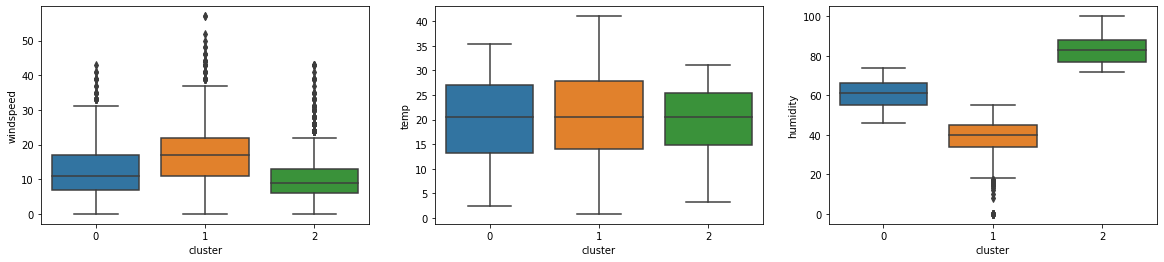

In [16]:
fig, axs = plt.subplots(1,3, figsize=(20,4))
sns.boxplot(ax=axs[0], data=df_pca, y=df_pca["windspeed"], x=df_pca.cluster)
sns.boxplot(ax=axs[1], data=df_pca, y=df_pca["temp"], x=df_pca.cluster)
sns.boxplot(ax=axs[2], data=df_pca, y=df_pca["humidity"], x=df_pca.cluster)

* <font color="green">Cluster 0 : Bon temps</font>
* <font color="red">Cluster 1 : Mauvais temps</font>
* Cluster 2 : Temps moyen

## Prediction du cluster avec regression logistique

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder

In [18]:
X = df
y = LabelEncoder().fit_transform(y_pred)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

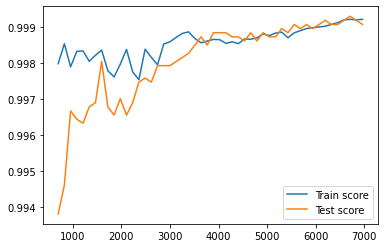

In [19]:
model = LogisticRegression(random_state=1, max_iter=700)
train_size, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1,1,50), cv=5)

plt.plot(train_size, train_score.mean(axis=1), label="Train score")
plt.plot(train_size, val_score.mean(axis=1), label= "Test score")
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [33]:
def scores(y_pred, y_true):
    print(f"Recall score : {recall_score(y_true, y_pred, average='weighted')}")
    print(f"Precision score : {precision_score(y_true, y_pred, average='weighted')}")
    print(f"F1 Score score : {f1_score(y_true, y_pred, average='weighted')}")
    print(f"Accuracy score : {accuracy_score(y_true, y_pred)}")

In [34]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Train score : {model.score(X_train, y_train)}")
print(f"Test score : {model.score(X_test, y_test)}")

Train score : 0.9994258153422141
Test score : 1.0


In [23]:
scores(y_pred, y_test)

Recall score : 1.0
Precision score : 1.0
F1 Score score : 1.0
Accuracy score : 1.0


Régression logistique très bon modèle pour prédire le cluster de la météo

In [25]:
import pickle

In [35]:
pickle.dump(model,open("model_cluster_weather.sav","wb"))

In [40]:
model_load = pickle.load(open("model_cluster_weather.sav","rb"))
model_load.predict(X_test)

array([2, 2, 1, ..., 1, 0, 2])

In [42]:
X_test.loc[0]

KeyError: 0